In [1]:
suppressMessages(library(caret))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggvenn))
suppressMessages(library(reshape2))
suppressMessages(library(pROC))
suppressMessages(library(magrittr))
suppressMessages(library(tidyr))
suppressMessages(library(stringr))
suppressMessages(library(DESeq2))
suppressMessages(library(binom))
suppressMessages(library(polycor))
gene.list = read.delim("../Files_For_Manuscript/gencode.biotype.name.key.tsv")


Warning message:
“package ‘DESeq2’ was built under R version 4.2.2”
Warning message:
“package ‘S4Vectors’ was built under R version 4.2.1”
Warning message:
“package ‘BiocGenerics’ was built under R version 4.2.1”
Warning message:
“package ‘IRanges’ was built under R version 4.2.1”
Warning message:
“package ‘GenomicRanges’ was built under R version 4.2.2”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.2.3”
Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.2.2”
Warning message:
“package ‘MatrixGenerics’ was built under R version 4.2.1”
Warning message:
“package ‘Biobase’ was built under R version 4.2.1”


In [26]:
r = metadata_all %>% filter(cohort == "R2D2")
table(r$sex)
r = metadata_all %>% filter(cohort == "GHL")
table(r$sex)
r = metadata_all %>% filter(cohort == "TBSQUARE")
table(r$sex)



r = metadata_all %>% filter(cohort == "R2D2")
table(r$tb)
r = metadata_all %>% filter(cohort == "GHL")
table(r$tb)
r = metadata_all %>% filter(cohort == "TBSQUARE")
table(r$tb)

nrow(norm_plot_dat_all)


Female   Male 
    41     57 


Female   Male 
    35     58 


Female   Male 
    19     41 


negative positive 
      48       50 


negative positive 
      36       57 


negative positive 
      25       35 

[1] 251

---
## Data Prep

    ###### NOTE ###### 

Cohort 1, 2 and 3 from
the manuscript are named  
by their original sample id and 
cohort names in the  
metadata and
count matrices.  

**For all code used here:  
Cohort 1 = GHL  
Cohort 2 = R2D2  
Cohort 3 (validation) = TBSQUARE**



In [2]:
#Set Seed 
set.seed(87)

# # Read in  Counts
counts_train = read.delim("../Files_For_Manuscript/counts.train.tsv")
counts_test = read.delim("../Files_For_Manuscript/counts.test.tsv")
counts_val = read.delim("../Files_For_Manuscript/counts.val.tsv")

# Read in Metadata
metadata_train = read.delim("../Files_For_Manuscript/metadata.train.tsv")
metadata_test = read.delim("../Files_For_Manuscript/metadata.test.tsv")
metadata_val = read.delim("../Files_For_Manuscript/metadata.val.tsv")

#Kisenyi and Mulago are sample collection sites from Uganda.
#We relabel them here as one country
metadata_train <- metadata_train %>%
  mutate(Country = ifelse(site %in% c("Kisenyi", "Mulago"), "Uganda", site))

metadata_test <- metadata_test %>%
  mutate(Country = ifelse(site %in% c("Kisenyi", "Mulago"), "Uganda", site))

metadata_val <- metadata_val %>%
  mutate(Country = ifelse(site %in% c("Kisenyi", "Mulago"), "Uganda", site))


metadata_all = rbind(metadata_train, metadata_test, metadata_val)

# DESEQ2

In [3]:
## Prepare data for Deseq2
meta_col = metadata_train
disc_cts = counts_train
#Subset Columns
meta_col = meta_col %>% select("sample_id", "tb")
rownames(meta_col) = meta_col$sample_id
#Check for alignment
all(colnames(disc_cts) == rownames(meta_col))


## run Deseq2 & extract results
dds <- DESeqDataSetFromMatrix(countData = disc_cts,
                             colData = meta_col,
                             design = ~ tb)
dds <- DESeq(dds)
res <- results(dds)

## Extract results
res_df = results(dds,alpha=0.05,contrast = c("tb","positive", "negative")) %>% data.frame()
#Get the Gene ID's as a column
res_df$gene_num = rownames(res_df)
#Merge with out labeled gene list to acquire gene names and info
res_df = merge(res_df, gene.list, by.x = "gene_num", by.y = "gene_id")
#Signifcant genes using padj<0.05
sigs = res_df %>% arrange(padj) %>% filter(padj < 0.05)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 312 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



---
## Normalize & wrangle data

In [4]:

#------------------------------------------------
## Normalize via VST
#------------------------------------------------

counts_train_norm <- DESeq2::varianceStabilizingTransformation(as.matrix(counts_train)) %>% data.frame() 
counts_test_norm <- DESeq2::varianceStabilizingTransformation(as.matrix(counts_test)) %>% data.frame() 
counts_val_norm <- DESeq2::varianceStabilizingTransformation(as.matrix(counts_val)) %>% data.frame() 


#------------------------------------------------
## Wrangle data into Plot Friendly Format
#------------------------------------------------

#Train data
norm_plot_dat_train = counts_train_norm %>%
    as.data.frame() %>% 
    tibble::rownames_to_column(., var = "gene_id") %>%
    gather(sample_id, value, -gene_id) %>%
    spread(gene_id, value)

norm_plot_dat_train = merge(norm_plot_dat_train, metadata_train, by.x = "sample_id")

#Test data
norm_plot_dat_test = counts_test_norm %>%
    as.data.frame() %>% 
    tibble::rownames_to_column(., var = "gene_id") %>%
    gather(sample_id, value, -gene_id) %>%
    spread(gene_id, value)

norm_plot_dat_test = merge(norm_plot_dat_test, metadata_test, by.x = "sample_id")

#Validation data
norm_plot_dat_val = counts_val_norm %>%
    as.data.frame() %>% 
    tibble::rownames_to_column(., var = "gene_id") %>%
    gather(sample_id, value, -gene_id) %>%
    spread(gene_id, value)

norm_plot_dat_val = merge(norm_plot_dat_val, metadata_val, by.x = "sample_id")

#Merge all for later figures
norm_plot_dat_all = rbind(norm_plot_dat_train, norm_plot_dat_test, norm_plot_dat_val)


---
# Run Greedy Forward Search (GFS)

In [5]:
# set new seed
set.seed(87)

# Get gene list
candidate_genes = res_df %>% 
    arrange(padj) %>% 
    #filter by padj
    filter(padj < 0.05) %>% 
    #Filter by baseMean
    filter(baseMean > 100) %>% 
    pull(gene_num)

# Load training data
df = norm_plot_dat_train 
# Prepare metadata (tb as factor)
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)

# Initialize variables for while loop
top_genes = c()
best_score <- 0
last_best_score = 0
while_var = 0

# Correlation will be used as a tie breaker
# in the case that two genes have an equal score
cor_plot_dat = norm_plot_dat_train

#------------------------------------------------
## Execute GFS on Training Data  
#------------------------------------------------
suppressWarnings(suppressMessages({
while(while_var != 1){

  gfs_output <- list()
  #------------------------------------------------
  # Loop through each candidate gene
  for (gene in candidate_genes) {

    # Create a temporary vector combining top_genes and the current gene
    temp_genes <- c(top_genes, gene)
    
    # Construct the formula and fit a GLM
    formula <- as.formula(paste("tb ~", paste(temp_genes, collapse = " + "), "- 1"))
    model_train <- glm(formula, data = df, family = "binomial")
    
    # Make predictions
    probs <- predict(model_train, newdata = df, type = "response")
    
    # Calculate roc object
    roc_train <- roc(df$tb, probs)
    coords_df <- data.frame(coords(roc_train, "all"))

    # Calculate the Youden's index for each row
    coords_df$youden <- coords_df$sensitivity + coords_df$specificity - 1

    # Choose the cutoff based on the optimal Youden's index
    optimal <- coords_df[which.max(coords_df$youden),]
    # Calculate the score at this cutoff
    all_score =  (optimal$specificity + optimal$sensitivity + auc(roc_train))

    # Caclulate the absolute value of the average correation
    # of all genes currently in the model with the current gene
    current_gene_data = cor_plot_dat[[gene]]
    top_genes_data = cor_plot_dat[, top_genes]
    cor_values = cor(current_gene_data, top_genes_data)
    average_cor = mean(cor_values)

    current_cor <- abs(average_cor)

    gfs_output[[gene]] <- c(all_score,current_cor)      
    }
    
  # Prepare dataframe to compare the score of all genes against one another
  gfs_res <- do.call("rbind", gfs_output) %>% data.frame()
  colnames(gfs_res) <- c("all_score","correlation")
  # Pick the single gene with the highest score, if there are ties, pick
  # lowest correlation to all previous genes
  top_performer <- gfs_res %>%
    arrange(desc(all_score),correlation) %>%
    head(1)
  # Save the score for the current set of genes
  best_score <- top_performer$all_score
  # Save the gene name for the best gene
  best_gene = top_performer %>% rownames()

  #------------------------------------------------
  # Check if the score increase is significant
  if ((best_score - last_best_score) > 0.01) {
    # if yes, add to gene list and save the score
    top_genes <- c(top_genes, best_gene)
    last_best_score <- best_score
  } else {
    # if not finish while loop and do not add the gene
    while_var <- 1 
  }
}
}))
#Print the significance of the genes
sigs %>% filter(gene_num %in% top_genes)

fin_genes = top_genes

gene_num,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,gene_type
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000154451.14,231.3465,1.4119155,0.15483242,9.118992,7.582640e-20,1.223762e-15,GBP5,protein_coding
ENSG00000104765.16,902.3648,-0.9075995,0.15070091,-6.022522,1.717203e-09,1.154748e-06,BNIP3L,protein_coding
ENSG00000135636.15,121.5238,0.6862966,0.13919540,4.930454,8.203859e-07,1.801677e-04,DYSF,protein_coding
ENSG00000002834.18,221.7770,0.2199719,0.05435484,4.046961,5.188696e-05,3.705326e-03,LASP1,protein_coding
ENSG00000169564.7,402.5393,0.3121914,0.08413228,3.710721,2.066695e-04,9.421552e-03,PCBP1,protein_coding
ENSG00000067082.15,103.0598,-0.4359739,0.12053530,-3.616981,2.980589e-04,1.184821e-02,KLF6,protein_coding


---
## Final Genes

In [6]:
# List the genes in the order selected by the GFS
ordered_gene_list <- gene.list %>%
  filter(gene_id %in% top_genes) %>%
  mutate(order = match(gene_id,top_genes)) %>%
  arrange(order) %>%
  select(-order)
ordered_gene_list


gene_id,gene_name,gene_type
<chr>,<chr>,<chr>
ENSG00000154451.14,GBP5,protein_coding
ENSG00000104765.16,BNIP3L,protein_coding
ENSG00000067082.15,KLF6,protein_coding
ENSG00000135636.15,DYSF,protein_coding
ENSG00000002834.18,LASP1,protein_coding
ENSG00000169564.7,PCBP1,protein_coding


---
## Calculate Performance Metrics
### Used throughout the paper and in figures

In [7]:
#----------------------------------

### TRAINING SET ####

#----------------------------------
df = norm_plot_dat_train
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)

gene_names <- as.character(top_genes)

# Construct the formula
formula <- as.formula(paste("tb ~", paste(gene_names, collapse = "+"), "- 1"))

# Create the GLM model
model_train <- glm(formula, data = df, family = "binomial")
#Calculate predictions
probs <- predict(model_train, newdata = df, type = "response")
# Create Calculate ROC and AUC
roc_train <- roc(df$tb, probs)
auc_train <- auc(roc_train)
roc_train_ci = ci.auc(roc_train)
coords_df <- data.frame(coords(roc_train, "all"))

# Calculate Youden's index for each row
coords_df$youden <- coords_df$sensitivity + coords_df$specificity - 1

# Choose the optimal Youden's index
optimal <- coords_df[which.max(coords_df$youden),]

# Print the AUC value
print(paste0("Training ROC-AUC: ", round(auc(roc_train),3)))
print(paste0("Training ROC-AUC 95% CI: [", round(roc_train_ci[1],3), "--", round(roc_train_ci[3],3), "]"))

# Print the optimal Youden threshold
print(paste("Optimal threshold: ", round(optimal$threshold,3)))

# Assign labels using optimal threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)
# Create Confusion matrix
conf_matrix_train <- table(df$tb, df$predicted)
# True positive
tp_train <- conf_matrix_train[2, 2]
# True Negative
tn_train <- conf_matrix_train[1, 1]
# Calculate the Accuracy
accuracy_train <- (tp_train + tn_train) / sum(conf_matrix_train)
print(paste("Train Accuracy: ", round(accuracy_train, 3)))

# Calculate the Sensitivity
sensitivity_train <- tp_train / (tp_train + conf_matrix_train[2, 1])
# Calculate the Specificity
specificity_train <- tn_train / (tn_train + conf_matrix_train[1, 2])

### 95% CI for Sensitivity and Specificity ###
# Set z-score for a two tailed 95% confidence test
z <- qnorm(0.975)

# Calculate the number of true positives and true negatives
n_tp <- tp_train + conf_matrix_train[2, 1]  # TP + FN
n_tn <- tn_train + conf_matrix_train[1, 2]  # TN + FP

# Calculate the standard error for sensitivity and specificity
se_sensitivity <- sqrt(sensitivity_train * (1 - sensitivity_train) / n_tp)
se_specificity <- sqrt(specificity_train * (1 - specificity_train) / n_tn)

# Calculate 95% CI for sensitivity
ci_lower_sensitivity <- sensitivity_train - z * se_sensitivity
ci_upper_sensitivity <- sensitivity_train + z * se_sensitivity

# Calculate 95% CI for specificity
ci_lower_specificity <- specificity_train - z * se_specificity
ci_upper_specificity <- specificity_train + z * se_specificity

# Print 95% CI
print(paste("Train Sensitivity: ", round(sensitivity_train, 3)))
print(paste("Train Sensitivity:  95% CI: [", round(ci_lower_sensitivity, 3), ",", round(ci_upper_sensitivity, 4), "]"))
print(paste("Train Specificity: ", round(specificity_train, 3)))
print(paste("Train Specificity:  95% CI: [", round(ci_lower_specificity, 3), ",", round(ci_upper_specificity, 4), "]"))

#----------------------------------

### TEST SET ####

#----------------------------------
df = norm_plot_dat_test

df$tb <- ifelse(df$tb == "positive", 1, 0)

df$tb <- as.factor(df$tb)

gene_names <- as.character(top_genes)


# Calculate predictions
probs <- predict(model_train, newdata = df, type = "response")

# Calculate ROC and AUC
roc_test <- roc(df$tb, probs)
roc_test_ci = ci.auc(roc_test)
print(paste0("Test ROC-AUC: ",round(auc(roc_test),3)))
print(paste0("Test ROC-AUC 95% CI: [", round(roc_test_ci[1],3), "--", round(roc_test_ci[3],3), "]"))

# Assign labels using optimal threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)

# Create a confusion matrix
conf_matrix <- table(df$tb, df$predicted)

# Get all labels for true positive, false positive, etc...
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Accuracy
accuracy_test <- (tp + tn) / sum(conf_matrix)
print(paste("Test Accuracy: ", round(accuracy_test, 3)))
# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Test", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Test Sensitivity: ", 
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Test", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Test Specificity: ", 
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

#----------------------------------

### VALIDATION SET ####

#----------------------------------

df = norm_plot_dat_val
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)
gene_names <- as.character(top_genes)

# Make predictions 
probs <- predict(model_train, newdata = df, type = "response")

# Calculate coordinates & scores
roc_val <- roc(df$tb, probs)
roc_val_ci = ci.auc(roc_val)
print(paste0("Validation ROC-AUC: ",round(auc(roc_val),3)))
print(paste0("Validation ROC-AUC 95% CI: [", round(roc_val_ci[1],3), "--", round(roc_val_ci[3],3), "]"))


# Assign class labels based on the threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)

# Create a confusion matrix and calculate sensitivity and specificity
conf_matrix <- table(df$tb, df$predicted)
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)


# Calculate accuracy
accuracy_val <- (tp + tn) / sum(conf_matrix)
print(paste("Validation Accuracy: ", round(accuracy_val, 3)))

# Calculate sensitivity and specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Validation", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Validation Sensitivity: ", 
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Validation", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Validation Specificity: ", 
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Training ROC-AUC: 0.921"
[1] "Training ROC-AUC 95% CI: [0.872--0.971]"
[1] "Optimal threshold:  0.498"
[1] "Train Accuracy:  0.915"
[1] "Train Sensitivity:  0.945"
[1] "Train Sensitivity:  95% CI: [ 0.893 , 0.9974 ]"
[1] "Train Specificity:  0.877"
[1] "Train Specificity:  95% CI: [ 0.792 , 0.9624 ]"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Test ROC-AUC: 0.947"
[1] "Test ROC-AUC 95% CI: [0.888--1]"
[1] "Test Accuracy:  0.918"
[1] "Test Sensitivity:  0.971"
[1] "Test Sensitivity:  95% CI: [ 0.851 , 0.995 ]"
[1] "Test Specificity:  0.852"
[1] "Test Specificity:  95% CI: [ 0.675 , 0.941 ]"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Validation ROC-AUC: 0.946"
[1] "Validation ROC-AUC 95% CI: [0.894--0.999]"
[1] "Validation Accuracy:  0.883"
[1] "Validation Sensitivity:  0.971"
[1] "Validation Sensitivity:  95% CI: [ 0.855 , 0.995 ]"
[1] "Validation Specificity:  0.76"
[1] "Validation Specificity:  95% CI: [ 0.566 , 0.885 ]"


---
# BEGIN FIGURES
---

# Figure 2A

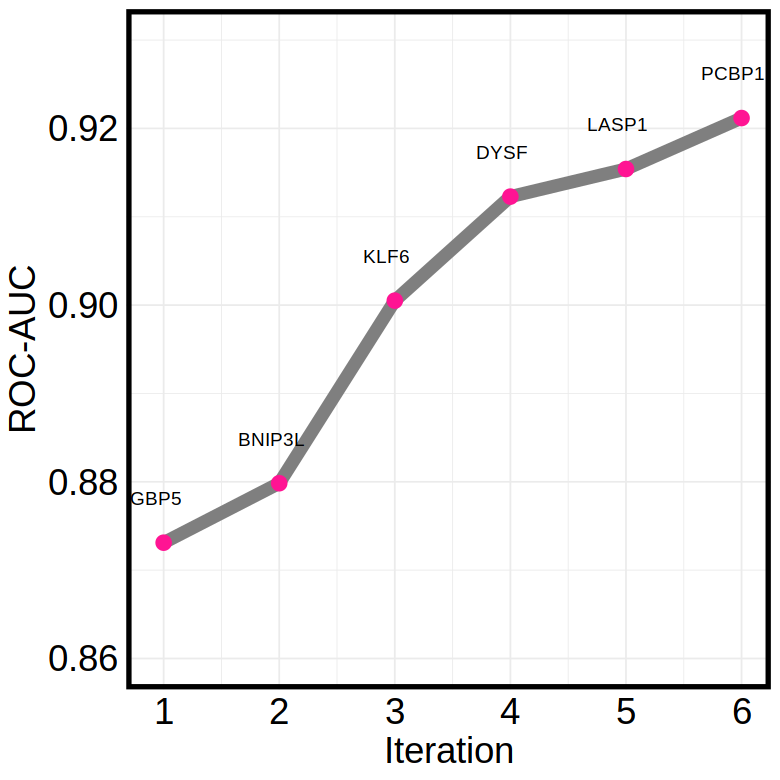

In [8]:
## Note:
## Arrows and gene names were inserted manually
## in adobe illustrator

options(repr.plot.height=6.5, repr.plot.width= 6.5)
suppressWarnings(suppressMessages({

# Set genes
genes = top_genes
# Set training data
df= norm_plot_dat_train
# Prepare training data for plotting
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)
# Order significant genes according to the stepwise GFS 
ordered_genes = sigs %>% filter(gene_num %in% top_genes) %>% arrange(match(gene_num, top_genes))
# Extract gene names in the order they appear in top_genes
gene_names = ordered_genes$gene_name
auc_values <- numeric(length(top_genes))

# Create a list which represents the AUC at each step of the GFS
# Trains a GLM for each step of the GFS and saves the result
for(i in 1:length(top_genes)){
  genes = top_genes %>% head(i)
  formula <- as.formula(paste("tb ~", paste(genes, collapse = "+"), "- 1"))
  model <- glm(formula, data = df, family = "binomial")
  probs <- predict(model, newdata = df, type = "response")
  roc_obj <- roc(df$tb, probs)
  auc_values[i] <- auc(roc_obj)
}

# Create the plot dataframe with x = iteration, y = auc, label = gene name
df_plot <- data.frame(GenesAdded = 1:length(top_genes), AUC = auc_values, GeneName = gene_names)

# Plot data
p = ggplot(df_plot, aes(x = GenesAdded, y = AUC, label = GeneName)) +
  geom_line(group = 1, color="grey50", size = 3.7) +
  geom_point(color = "deeppink", size = 4) +
  # To create plot without labels remove the line below this
  geom_text(nudge_y = 0.005,nudge_x = -0.07, check_overlap = TRUE, size = 4) +
  labs(x = "Iteration", y = "ROC-AUC") +
  scale_x_continuous(breaks = scales::pretty_breaks()) +
  theme_bw(base_size=6) + xlab("Iteration") + ylab("ROC-AUC") + 
  ylim(0.86, 0.93) + theme_minimal() +
  theme(axis.text = element_text(size=22, color="black"),
        axis.title = element_text(size=22, color="black"),
        axis.line = element_line(size = 0, color = "black"),
        panel.border = element_rect(color = "black", fill = NA, size = 3))

}))
p
ggsave("../Figure_Output/Figure_2/Fig2A.png", plot = p, width = 5.3, height = 5.5, dpi = 300)
ggsave("../Figure_Output/Figure_2/Fig2A.pdf", plot = p, width = 3, height = 3, dpi = 300, device = "pdf")

---
# FIGURE 2 B

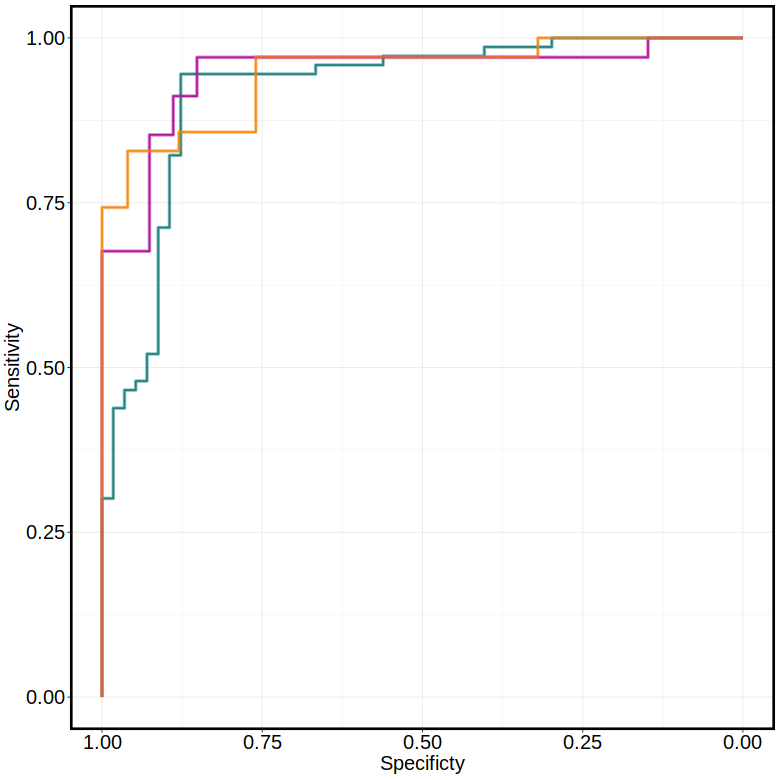

In [9]:
p = ggroc(list("Train"= roc_train, "Test" = roc_test, "Validation"=roc_val), aes=c("color"))  +
    theme_bw(base_size=6) + guides(color="none", linetype="none") +
    geom_line(size=1,alpha=0.5) + scale_color_manual(values=c("#218380","#B5179E","#F88C1A")) +
    xlab("Specificty") + ylab("Sensitivity") +
    theme(axis.text=element_text(size=12, color="black"), 
          axis.title=element_text(size=12, color="black"),
          panel.border = element_rect(size = 1.5, color ="black"))  # Adjust this line to change the thickness

ggsave("../Figure_Output/Figure_2/Fig2B.png", plot = p, width = 3, height = 2.85, dpi = 300)
ggsave("../Figure_Output/Figure_2/Fig2B.pdf", plot = p, width = 3, height = 2.85, device = "pdf")

p

---
# Figure 2C
### Legend for this plot was created manually in adobe illustrator

Setting levels: control = 0, case = 1

Setting direction: controls < cases



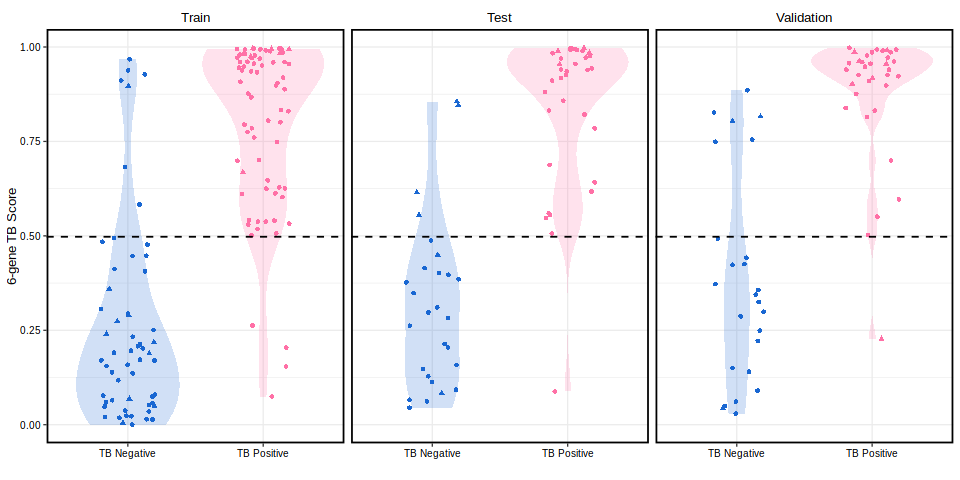

In [10]:
options( repr.plot.width=8, repr.plot.height=4)
set.seed(87)
palette <- c("#1967d2ff", "#FF70A6")
# Train model again here to ensure code reproducibility across code blocks
#------------------------
df = norm_plot_dat_train
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)
gene_names <- as.character(top_genes)
# Construct the formula
formula <- as.formula(paste("tb ~", paste(gene_names, collapse = "+"), "- 1"))
# Create the GLM model
model_train <- glm(formula, data = df, family = "binomial")
probs <- predict(model_train, newdata = df, type = "response")
roc_train <- roc(df$tb, probs)
coords_df <- data.frame(coords(roc_train, "all"))
# Calculate Youden's index for each row
coords_df$youden <- coords_df$sensitivity + coords_df$specificity - 1
# Choose the optimal Youden's index
optimal <- coords_df[which.max(coords_df$youden),]
#--------------------------------------------------------------------

# Create temporary plotting dataframes for train, test, validation
# And use the model to predict on all of them
df_train = norm_plot_dat_train
df_train$tb <- ifelse(df_train$tb == "positive", 1, 0)
df_train$tb <- as.factor(df_train$tb)
df_train$predicted_probs <- predict(model_train, newdata = df_train, type = "response")

df_test = norm_plot_dat_test
df_test$tb <- ifelse(df_test$tb == "positive", 1, 0)
df_test$tb <- as.factor(df_test$tb)
df_test$predicted_probs <- predict(model_train, newdata = df_test, type = "response")

df_val = norm_plot_dat_val
df_val$tb <- ifelse(df_val$tb == "positive", 1, 0)
df_val$tb <- as.factor(df_val$tb)
df_val$predicted_probs <- predict(model_train, newdata = df_val, type = "response")

# Assign labels for each dataframe
df_train$type <- "Train"
df_test$type <- "Test"
df_val$type <- "Validation"
# Combine the dataframes for plotting
combined_df <- rbind(df_train, df_test, df_val)
# Set the train, test, val labels as levels
combined_df$type <- factor(combined_df$type, levels = c("Train", "Test", "Validation"))

# Create a plot with facet_wrap for horizontal layout
combined_plot <- ggplot(combined_df, aes(x = tb, y = predicted_probs, fill = tb)) +
  geom_violin(color = NA, alpha = 0.2) +
  geom_jitter(aes(color = tb, shape = hiv), size = 1, position = position_jitter(width = 0.2, height = 0)) +
# Plot the threshold
  geom_hline(yintercept = optimal$threshold, linetype = "dashed") +
  scale_fill_manual(values = palette) +
  scale_color_manual(values = palette) +
  scale_x_discrete(labels = c(`0` = "TB Negative", `1` = "TB Positive")) +
  facet_wrap(~ type, ncol = 3, scales = "free_x") +
  labs(y = "Predicted Probability", x = "") +
  theme_bw(base_size = 8) +
  theme(legend.position = "none",
        axis.text = element_text(size = 6, color = "black"),
        strip.background = element_rect(color = "#FFFFFF", fill = "#FFFFFF", size = 0),
        strip.text.x = element_text(size = 8, color = "black"),
        panel.border = element_rect(colour = "black", fill = NA, size = 1)) +
  ylab("6-gene TB Score")

# Display the combined plot
print(combined_plot)

# Save the combined plot with adjusted width
ggsave("../Figure_Output/Figure_2/Fig2C.png", plot = combined_plot, width = 4, height = 2, dpi = 300)
ggsave("../Figure_Output/Figure_2/Fig2C.pdf", plot = combined_plot, width = 4, height = 2, dpi = 300, device = "pdf")


---
# Figure 2D

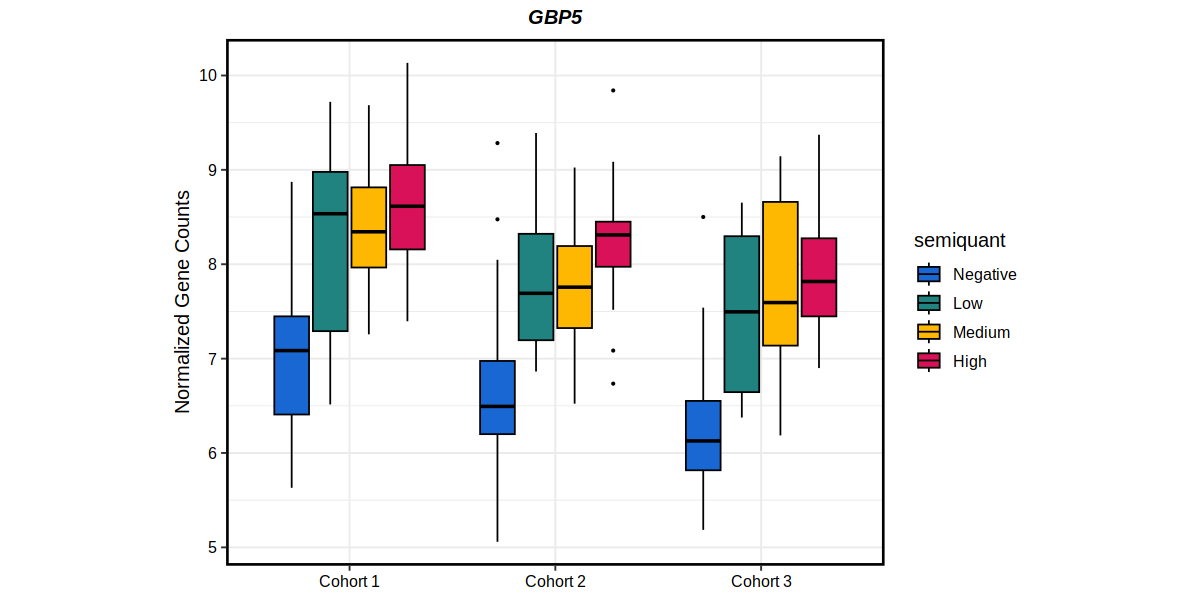

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)
# Create temporary dataframe for all samples
df = norm_plot_dat_all

# Filter the data for the gene GBP5
df_gbp5 <- df %>%
  select(cohort, semiquant, ENSG00000154451.14) %>%
  #Remove any samples that are missing semiquant values
  filter(!is.na(semiquant)) %>%
  filter(semiquant != "") %>%
  #Set semiquant as a factor for plotting
  mutate(semiquant = factor(semiquant, levels = c("Negative", "Low", "Medium", "High")))

# Plot
p = ggplot(df_gbp5, aes(x = cohort, y = ENSG00000154451.14, fill = semiquant)) +
  geom_boxplot(outlier.size = 0.5, color = "black") + 
  theme_bw(base_size = 12) +
  theme(axis.text.x = element_text(color = "black"),
        axis.title.x = element_blank(),
        axis.text = element_text(color = "black"), 
        axis.title = element_text(color = "black"), 
        title = element_text(size = 12, color = "black"), 
        strip.background = element_rect(color = "#FFFFFF", fill = "#FFFFFF", size = 0),
        strip.text.x = element_text(size = 12, color = "black", face = "bold.italic"),
        panel.border = element_rect(colour = "black", fill = NA, size = 1.5),
        panel.spacing.y = unit(0.15, "mm"),
        aspect.ratio = 0.8) +
  scale_fill_manual(values = c("#1967d2ff", "#218380", "#FFB802", "#D81159", "#D81159")) + 
  scale_x_discrete(labels = c("Cohort 1", "Cohort 2", "Cohort 3")) +
  ylab("Normalized Gene Counts") +
  ggtitle("GBP5") +
  theme(plot.title = element_text(hjust = 0.5, color = "black", size = 12, face = "bold.italic"))

# Display the plot
p

# Saving the plot with the styled title
ggsave(filename = "../Figure_Output/Figure_2/Fig2D.png", plot = p, width = 7, height = 2.3, dpi = 300)
ggsave(filename = "../Figure_Output/Figure_2/Fig2D.pdf", plot = p, width = 7, height = 2.3, dpi = 300, device = "pdf")


---
# Figure 2E

In [12]:
#----------------------------------

### Train the model ####

#----------------------------------
df = norm_plot_dat_train
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)

gene_names <- as.character(top_genes)

# Construct the formula
formula <- as.formula(paste("tb ~", paste(gene_names, collapse = "+"), "- 1"))

# Create the GLM model
model_train <- glm(formula, data = df, family = "binomial")
#Calculate predictions
probs <- predict(model_train, newdata = df, type = "response")
# Create Calculate ROC and AUC
roc_train <- roc(df$tb, probs)
auc_train <- auc(roc_train)
roc_train_ci = ci.auc(roc_train)
coords_df <- data.frame(coords(roc_train, "all"))

# Calculate Youden's index for each row
coords_df$youden <- coords_df$sensitivity + coords_df$specificity - 1

# Choose the optimal Youden's index
optimal <- coords_df[which.max(coords_df$youden),]

#----------------------------------

### Training Set ####

#----------------------------------

df = norm_plot_dat_train
# Filter for patients without HIV
df = df %>% filter(hiv == "Negative")
df$tb <- ifelse(df$tb == "positive", 1, 0)

df$tb <- as.factor(df$tb)

gene_names <- as.character(top_genes)


# Calculate predictions
probs <- predict(model_train, newdata = df, type = "response")

# Calculate ROC and AUC
roc_train <- roc(df$tb, probs)
roc_train_ci = ci.auc(roc_train)
print(paste0("Train ROC-AUC: ",round(auc(roc_train),3)))
print(paste0("Train ROC-AUC 95% CI: [", round(roc_train_ci[1],3), "--", round(roc_train_ci[3],3), "]"))

# Assign labels using optimal threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)

# Create a confusion matrix
conf_matrix <- table(df$tb, df$predicted)

# Get all labels for true positive, false positive, etc...
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Accuracy
accuracy_test <- (tp + tn) / sum(conf_matrix)
print(paste("Train Accuracy: ", round(accuracy_test, 3)))
# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Train", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Train Sensitivity: ", 
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Train", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Train Specificity: ", 
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

#----------------------------------

### TEST SET ####

#----------------------------------
df = norm_plot_dat_test
df = df %>% filter(hiv == "Negative")
df$tb <- ifelse(df$tb == "positive", 1, 0)

df$tb <- as.factor(df$tb)

gene_names <- as.character(top_genes)


# Calculate predictions
probs <- predict(model_train, newdata = df, type = "response")

# Calculate ROC and AUC
roc_test <- roc(df$tb, probs)
roc_test_ci = ci.auc(roc_test)
print(paste0("Test ROC-AUC: ",round(auc(roc_test),3)))
print(paste0("Test ROC-AUC 95% CI: [", round(roc_test_ci[1],3), "--", round(roc_test_ci[3],3), "]"))

# Assign labels using optimal threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)

# Create a confusion matrix
conf_matrix <- table(df$tb, df$predicted)

# Get all labels for true positive, false positive, etc...
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Accuracy
accuracy_test <- (tp + tn) / sum(conf_matrix)
print(paste("Test Accuracy: ", round(accuracy_test, 3)))
# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Test", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Test Sensitivity: ", 
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Test", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Test Specificity: ", 
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

#----------------------------------

### VALIDATION SET ####

#----------------------------------

df = norm_plot_dat_val
df = df %>% filter(hiv == "Negative")
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)
gene_names <- as.character(top_genes)

# Make predictions 
probs <- predict(model_train, newdata = df, type = "response")

# Calculate coordinates & scores
roc_val <- roc(df$tb, probs)
roc_val_ci = ci.auc(roc_val)
print(paste0("Validation ROC-AUC: ",round(auc(roc_val),3)))
print(paste0("Validation ROC-AUC 95% CI: [", round(roc_val_ci[1],3), "--", round(roc_val_ci[3],3), "]"))


# Assign class labels based on the threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)

# Create a confusion matrix and calculate sensitivity and specificity
conf_matrix <- table(df$tb, df$predicted)
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)


# Calculate accuracy
accuracy_val <- (tp + tn) / sum(conf_matrix)
print(paste("Validation Accuracy: ", round(accuracy_val, 3)))

# Calculate sensitivity and specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Validation", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Validation Sensitivity: ", 
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Validation", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Validation Specificity: ", 
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Train ROC-AUC: 0.914"
[1] "Train ROC-AUC 95% CI: [0.856--0.972]"
[1] "Train Accuracy:  0.912"
[1] "Train Sensitivity:  0.939"
[1] "Train Sensitivity:  95% CI: [ 0.854 , 0.976 ]"
[1] "Train Specificity:  0.872"
[1] "Train Specificity:  95% CI: [ 0.748 , 0.94 ]"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Test ROC-AUC: 0.971"
[1] "Test ROC-AUC 95% CI: [0.915--1]"
[1] "Test Accuracy:  0.98"
[1] "Test Sensitivity:  0.967"
[1] "Test Sensitivity:  95% CI: [ 0.833 , 0.994 ]"
[1] "Test Specificity:  1"
[1] "Test Specificity:  95% CI: [ 0.845 , 1 ]"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Validation ROC-AUC: 0.966"
[1] "Validation ROC-AUC 95% CI: [0.925--1]"
[1] "Validation Accuracy:  0.92"
[1] "Validation Sensitivity:  1"
[1] "Validation Sensitivity:  95% CI: [ 0.879 , 1 ]"
[1] "Validation Specificity:  0.818"
[1] "Validation Specificity:  95% CI: [ 0.615 , 0.927 ]"


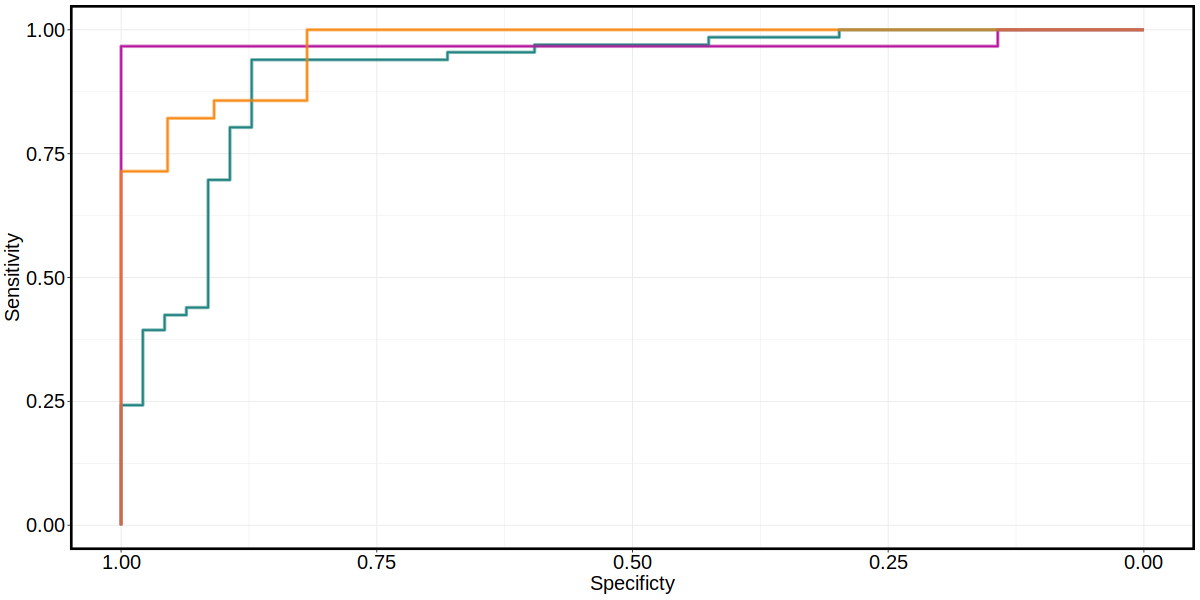

In [13]:
## Save ROC Curves of HIV Negative Patients ##
p = ggroc(list("Train"= roc_train, "Test" = roc_test, "Validation"=roc_val), aes=c("color"))  +
    theme_bw(base_size=6) + guides(color="none", linetype="none") +
    geom_line(size=1,alpha=0.5) + scale_color_manual(values=c("#218380","#B5179E","#F88C1A")) +
    xlab("Specificty") + ylab("Sensitivity") +
    theme(axis.text=element_text(size=12, color="black"), 
          axis.title=element_text(size=12, color="black"),
          panel.border = element_rect(size = 1.5, color ="black"))  # Adjust this line to change the thickness

ggsave("../Figure_Output/Figure_2/Fig2E.png", plot = p, width = 3, height = 2.85, dpi = 300)
ggsave("../Figure_Output/Figure_2/Fig2E.pdf", plot = p, width = 3, height = 2.85, device = "pdf")

p

---
# Figure 2F

In [14]:
#----------------------------------

### TRAIN THE MODEL ####

#----------------------------------
df = norm_plot_dat_train
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)

gene_names <- as.character(top_genes)

# Construct the formula
formula <- as.formula(paste("tb ~", paste(gene_names, collapse = "+"), "- 1"))

# Create the GLM model
model_train <- glm(formula, data = df, family = "binomial")
#Calculate predictions
probs <- predict(model_train, newdata = df, type = "response")
# Create Calculate ROC and AUC
roc_train <- roc(df$tb, probs)
auc_train <- auc(roc_train)
roc_train_ci = ci.auc(roc_train)
coords_df <- data.frame(coords(roc_train, "all"))

# Calculate Youden's index for each row
coords_df$youden <- coords_df$sensitivity + coords_df$specificity - 1

# Choose the optimal Youden's index
optimal <- coords_df[which.max(coords_df$youden),]

#----------------------------------

### Uganda Patients Only ####

#----------------------------------
# Read in all sample
df = norm_plot_dat_all
# Filter for samples from Uganda
df = df %>% filter(Country == "Uganda")

df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)
gene_names <- as.character(top_genes)


# Calculate predictions
probs <- predict(model_train, newdata = df, type = "response")

# Calculate ROC and AUC
roc_ug <- roc(df$tb, probs)
roc_ug_ci = ci.auc(roc_ug)
print(paste0("Uganda ROC-AUC: ",round(auc(roc_ug),3)))
print(paste0("Uganda ROC-AUC 95% CI: [", round(roc_ug_ci[1],3), "--", round(roc_ug_ci[3],3), "]"))

# Assign labels using optimal threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)

# Create a confusion matrix
conf_matrix <- table(df$tb, df$predicted)

# Get all labels for true positive, false positive, etc...
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Accuracy
accuracy_test <- (tp + tn) / sum(conf_matrix)
print(paste("Uganda Accuracy: ", round(accuracy_test, 3)))
# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Uganda", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Uganda Sensitivity: ", 
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Uganda", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Uganda Specificity: ", 
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

#----------------------------------

### Vietnam Patients Only ####

#----------------------------------
df = norm_plot_dat_all
df = df %>% filter(Country == "Vietnam")
df$tb <- ifelse(df$tb == "positive", 1, 0)

df$tb <- as.factor(df$tb)

gene_names <- as.character(top_genes)


# Calculate predictions
probs <- predict(model_train, newdata = df, type = "response")

# Calculate ROC and AUC
roc_vi <- roc(df$tb, probs)
roc_vi_ci = ci.auc(roc_vi)
print(paste0("Vietnam ROC-AUC: ",round(auc(roc_vi),3)))
print(paste0("Vietnam ROC-AUC 95% CI: [", round(roc_vi_ci[1],3), "--", round(roc_vi_ci[3],3), "]"))

# Assign labels using optimal threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)

# Create a confusion matrix
conf_matrix <- table(df$tb, df$predicted)

# Get all labels for true positive, false positive, etc...
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Accuracy
accuracy_test <- (tp + tn) / sum(conf_matrix)
print(paste("Vietnam Accuracy: ", round(accuracy_test, 3)))
# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Vietnam", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Vietnam Sensitivity: ", 
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Vietnam", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Vietnam Specificity: ", 
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

#----------------------------------

### Philippines Patients Only ####

#----------------------------------

df = norm_plot_dat_all
df = df %>% filter(Country == "Philippines")
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)
gene_names <- as.character(top_genes)

# Make predictions 
probs <- predict(model_train, newdata = df, type = "response")

# Calculate coordinates & scores
roc_ph <- roc(df$tb, probs)
roc_ph_ci = ci.auc(roc_ph)
print(paste0("Philippines ROC-AUC: ",round(auc(roc_ph),3)))
print(paste0("Philippines ROC-AUC 95% CI: [", round(roc_ph_ci[1],3), "--", round(roc_ph_ci[3],3), "]"))


# Assign class labels based on the threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)

# Create a confusion matrix and calculate sensitivity and specificity
conf_matrix <- table(df$tb, df$predicted)
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)


# Calculate accuracy
accuracy_val <- (tp + tn) / sum(conf_matrix)
print(paste("Philippines Accuracy: ", round(accuracy_val, 3)))

# Calculate sensitivity and specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Philippines", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Philippines Sensitivity: ", 
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Philippines", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Philippines Specificity: ", 
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Uganda ROC-AUC: 0.927"
[1] "Uganda ROC-AUC 95% CI: [0.89--0.964]"
[1] "Uganda Accuracy:  0.905"
[1] "Uganda Sensitivity:  0.964"
[1] "Uganda Sensitivity:  95% CI: [ 0.911 , 0.986 ]"
[1] "Uganda Specificity:  0.821"
[1] "Uganda Specificity:  95% CI: [ 0.721 , 0.89 ]"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Vietnam ROC-AUC: 0.903"
[1] "Vietnam ROC-AUC 95% CI: [0.799--1]"
[1] "Vietnam Accuracy:  0.889"
[1] "Vietnam Sensitivity:  0.9"
[1] "Vietnam Sensitivity:  95% CI: [ 0.699 , 0.972 ]"
[1] "Vietnam Specificity:  0.875"
[1] "Vietnam Specificity:  95% CI: [ 0.64 , 0.965 ]"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Philippines ROC-AUC: 0.964"
[1] "Philippines ROC-AUC 95% CI: [0.889--1]"
[1] "Philippines Accuracy:  0.962"
[1] "Philippines Sensitivity:  1"
[1] "Philippines Sensitivity:  95% CI: [ 0.741 , 1 ]"
[1] "Philippines Specificity:  0.933"
[1] "Philippines Specificity:  95% CI: [ 0.702 , 0.988 ]"


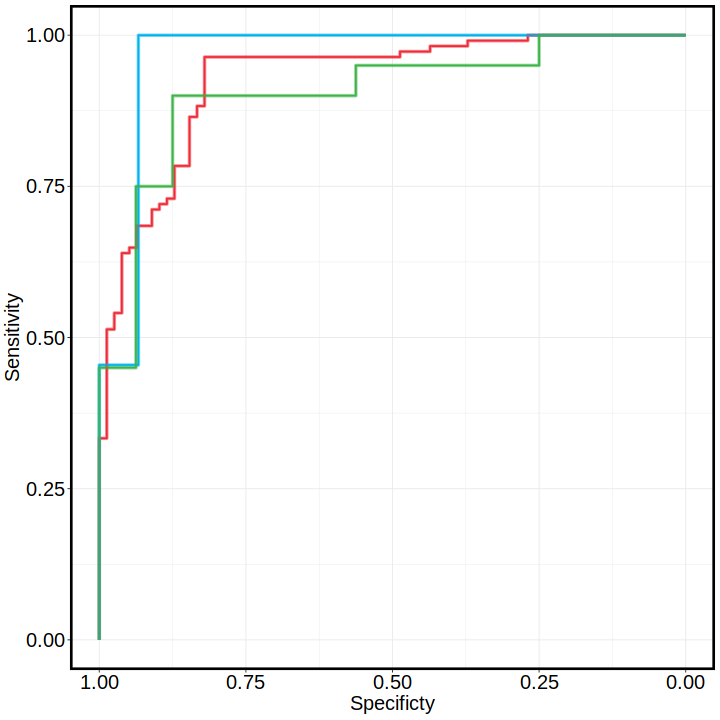

In [15]:
## Plot the Country ROC Curves ##
options(repr.plot.height=6, repr.plot.width=6)
p = ggroc(list("Train"= roc_ug, "Test" = roc_ph, "Validation"=roc_vi), aes=c("color"))  +
    theme_bw(base_size=6) + guides(color="none", linetype="none") +
    geom_line(size=1,alpha=0.5) + scale_color_manual(values=c("#EE2C39","#00B2EC","#3FB349")) +
    xlab("Specificty") + ylab("Sensitivity") +
    theme(axis.text=element_text(size=12, color="black"), 
          axis.title=element_text(size=12, color="black"),
          panel.border = element_rect(size = 1.5, color ="black"))  # Adjust this line to change the thickness

ggsave("../Figure_Output/Figure_2/Fig2F.png", plot = p, width = 3, height = 2.85, dpi = 300)
ggsave("../Figure_Output/Figure_2/Fig2F.pdf", plot = p, width = 3, height = 2.85, device = "pdf")

p

---
# Figure 2G

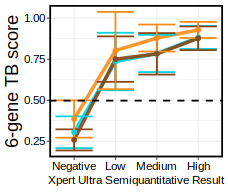

In [16]:
## Note 
## the Key To label the Cohorts colors was 
## added in adobe illustrator
## For this plot Teal = Cohort 1, Brown = Cohort 2, Yellow = Cohort 3

## Train the model to ensure reproducibility of code blocks
df =  norm_plot_dat_train
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)
gene_names <- as.character(top_genes)

# Construct the formula using the gene names
formula <- as.formula(paste("tb ~", paste(gene_names, collapse = "+"), "- 1"))

# Next, create the logistic regression model
model_train <- glm(formula,
             data = df, family = "binomial")

# Predict the probabilities for the positive class
probs <- predict(model_train, newdata = df, type = "response")


# Predict make the predictions on all samples as save as a column
norm_plot_dat_all$probs <- predict(model_train, newdata = norm_plot_dat_all, type = "response")

# Function to compute error bar stats
compute_summary <- function(df){
  df %>%
    filter(!is.na(semiquant)) %>%
    mutate(semiquant = factor(semiquant, levels = c("Negative", "Low", "Medium", "High"))) %>%
    group_by(semiquant, cohort) %>%
    summarise(mean = mean(probs, na.rm = TRUE),
              sd = sd(probs, na.rm = TRUE),
              n = n(),
              se = sd / sqrt(n),
              lower.ci = ifelse(n == 1, NA, mean - qt(1 - (0.05 / 2), n - 1) * se),
              upper.ci = ifelse(n == 1, NA, mean + qt(1 - (0.05 / 2), n - 1) * se),
              .groups = 'drop')
}


# Apply function
combined_df  <- compute_summary(norm_plot_dat_all)

combined_df$cohort <- factor(combined_df$cohort, levels = unique(combined_df$cohort))

# Plotting
options(repr.plot.height=1.6, repr.plot.width=1.9)
p <- combined_df %>%
  filter(!is.na(semiquant)) %>%
  ggplot(aes(x = semiquant, y = mean, color = cohort, group = cohort)) + 
  geom_line(size = 1, alpha = 0.9) + 
  geom_errorbar(aes(ymin = lower.ci, ymax = upper.ci)) + 
  geom_point(size = 1, alpha = 0.9) + 
  theme_bw(base_size = 6) +
   theme(legend.position = "none",
        axis.text = element_text(color = "black", size = 7),
        axis.title.x = element_text(color = "black", size = 7),
        axis.title.y = element_text(color = "black", size = 11), # Y-axis label size increased
        panel.border = element_rect(colour = "black", fill = NA, size = 1)) +
  xlab("Xpert Ultra Semiquantitative Result") + 
  ylab("6-gene TB score") +
  scale_color_manual(values = c("#00D2DE", "#8B4514", "#F88C1A")) + # Ensure these colors match your cohorts
  geom_hline(yintercept = optimal$threshold, linetype = "dashed")
p

ggsave(filename = "../Figure_Output/Figure_2/Fig2G.png", plot = p, width = 2.4, height = 1.9, dpi = 300)
ggsave(filename = "../Figure_Output/Figure_2/fig2G.pdf", plot = p, width = 2.2, height = 1.9, dpi = 300, device = "pdf")

In [17]:
# Calculate the polychoric correlation between semiquantitative groups
df = norm_plot_dat_all
# Check if both 'probs' and 'semiquant' columns exist in df

  # Set semiquant as an ordered factor
  df$semiquant <- factor(df$semiquant, levels = c("Negative", "Low", "Medium", "High"), ordered = TRUE)

  # Calculate polychoric correlation
  polychoric_correlation <- hetcor(df[, c("probs", "semiquant")])

  # Print the polychoric correlation
  print(polychoric_correlation)
print(paste0("Polychoric correlation: ",round(polychoric_correlation$correlations[2],3)))


Two-Step Estimates

Correlations/Type of Correlation:
           probs  semiquant
probs          1 Polyserial
semiquant 0.7574          1

Standard Errors:
[1] ""        "0.02738"

n = 244 

P-values for Tests of Bivariate Normality:
[1] ""          "2.053e-29"
[1] "Polychoric correlation: 0.757"


---
# Figure 2H

## Plot 1: CAD4TB plot
### Legends for this plot were created manually in adobe illustrator

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 104 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 104 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 104 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 104 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 104 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 104 rows containing missing values (`geom_point()`).”


cor
<dbl>
0.616099


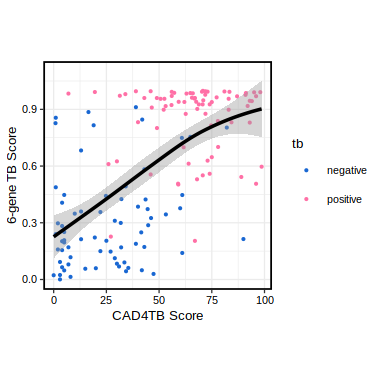

In [18]:
options(repr.plot.height=3.2, repr.plot.width=3.2)

# Set temorary dataframe for all sample points
comb_df = norm_plot_dat_all

# Plot
p = comb_df %>% 
  
  ggplot(aes(x=CAD4TB_score, y=probs, color=tb)) + 
  geom_point(size=0.5) +
  theme_bw(base_size=8) + 
  geom_smooth(method="loess", span=2, color="black") + scale_y_continuous(limits=c(0, 1.1)) +
  theme( 
    axis.text=element_text(size=6, color="black"), 
    axis.title=element_blank()
  ) +
  xlab("CAD4TB Score")+
  ylab("6-gene TB Score") + 
  scale_color_manual(values=c("#1967d2ff", "#FF70A6")) +
  theme(
    aspect.ratio = 1,
    strip.background = element_blank(),
    strip.placement = "outside",
    axis.text=element_text(size=6.5, color="black"),
    axis.title=element_text(size=8, color="black"),
    panel.border = element_rect(colour = "black", fill = NA, size = 1)
  )
p
ggsave(filename = "../Figure_Output/Figure_2/Fig2H_1.png", plot = p, width = 1.6, height = 4.6, dpi = 300)
ggsave(filename = "../Figure_Output/Figure_2/Fig2H_1.pdf", plot = p, width = 1.6, height = 4.6, dpi = 300, device = pdf)

# Filter only for matching correlation values (probs and CAD4TB exist)
comb_df_filtered <- comb_df[complete.cases(comb_df$CAD4TB_score, comb_df$probs), ]
# Calculate Correlation
comb_df_filtered %>% summarise(cor = cor(CAD4TB_score, probs, method="pearson"))


## Plot 2: qXR Score Plot

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 101 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 101 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 101 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 101 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 101 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 101 rows containing missing values (`geom_point()`).”


cor
<dbl>
0.4973201


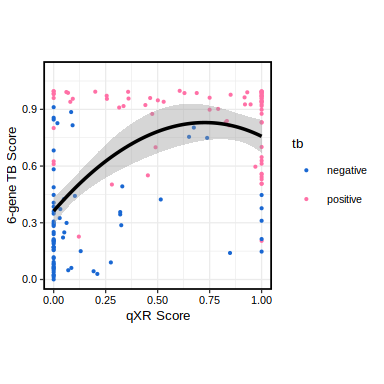

In [19]:

# Plot
p = comb_df %>% 
  ggplot(aes(x=qXR_score, y=probs, color=tb)) + 
  geom_point(size=0.5) +
  theme_bw(base_size=8) + 
  geom_smooth(method="loess", span=2, color="black") + scale_y_continuous(limits=c(0, 1.1)) +
  theme(
    axis.text=element_text(size=6, color="black"), 
    axis.title=element_blank()
  ) +
  xlab("qXR Score") +
  ylab("6-gene TB Score") + 
  scale_color_manual(values=c("#1967d2ff", "#FF70A6")) +
  theme(
    aspect.ratio = 1,
    strip.background = element_blank(),
    strip.placement = "outside",
    axis.text=element_text(size=6.5, color="black"),
    axis.title=element_text(size=8, color="black"),
    panel.border = element_rect(colour = "black", fill = NA, size = 1)
  )
p
ggsave(filename = "../Figure_Output/Figure_2/Fig2H_2.png", plot = p, width = 1.6, height = 4.6, dpi = 300)
ggsave(filename = "../Figure_Output/Figure_2/Fig2H_2.pdf", plot = p, width = 1.6, height = 4.6, dpi = 300, device = pdf)

comb_df_filtered <- comb_df[complete.cases(comb_df$qXR_score, comb_df$probs), ]
comb_df_filtered %>% summarise(cor = cor(qXR_score, probs, method="pearson"))


## Plot 3: Lunit Score Plot

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 101 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 101 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 101 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 101 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 101 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 101 rows containing missing values (`geom_point()`).”


cor
<dbl>
0.5209263


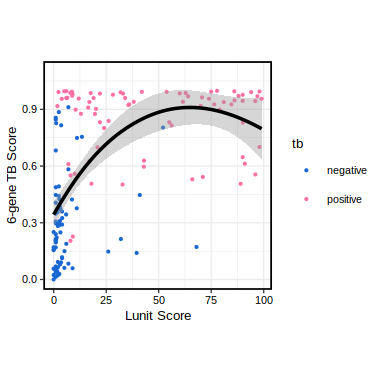

In [20]:

# Plotting the data
p = comb_df %>% 
  ggplot(aes(x=Lunit_score, y=probs, color=tb)) + 
  geom_point(size=0.5) +
  theme_bw(base_size=8) + 
  geom_smooth(method="loess", span=2, color="black") + scale_y_continuous(limits=c(0, 1.1)) +
  theme( 
    axis.text=element_text(size=6, color="black"), 
    axis.title=element_blank()
  ) +
  xlab("Lunit Score") +
  ylab("6-gene TB Score") + 
  scale_color_manual(values=c("#1967d2ff", "#FF70A6")) +
  theme(
    aspect.ratio = 1,
    strip.background = element_blank(),
    strip.placement = "outside",
    axis.text=element_text(size=6.5, color="black"),
    axis.title=element_text(size=8, color="black"),
    panel.border = element_rect(colour = "black", fill = NA, size = 1)
  )
p
ggsave(filename = "../Figure_Output/Figure_2/Fig2H_3.png", plot = p, width = 1.6, height = 4.6, dpi = 300)
ggsave(filename = "../Figure_Output/Figure_2/Fig2H_3.pdf", plot = p, width = 1.6, height = 4.6, dpi = 300, device = pdf)


comb_df_filtered <- comb_df[complete.cases(comb_df$Lunit_score, comb_df$probs), ]
comb_df_filtered %>% summarise(cor = cor(Lunit_score, probs, method="pearson"))
